In [147]:
import pandas as pd
import media_mapper as mm
import numpy as np
from sklearn.cluster import KMeans
import json
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
###get dataframe
df = mm.pipeline.retrieve_sql_tweets('tweets_with_geoV6')

In [3]:
df.head()

,timestamp_ms,geoid10,id
0,1436990735491,060750615003006,621410300290592768
1,1437945824772,060750134001000,625416235082194944
2,1438041259509,060759804011003,625816517381332992
3,1437873474604,060750101001001,625112776483188736
4,1437929054749,060750604001007,625345896507666432


##get a count for every day of the week, and hour of the day

In [4]:
#obtain hour and day of week variables
df  =mm.pipeline.transform_timestamp(df, hour = True, DOW = True)

In [5]:
def tweet_rate_by_hour(df, dow = False):
    '''Calculates tweets per hour from a dataframe with unqiue entries for tweets, 
    and a datetime column. Drops the id column.
    If dow is false, will return a dataframe grouped only by hour. 
    If dow is true, will return a dataframe grouped by weekend(0) or weekday (1).'''
    #column of ones serves as a counter for number of tweets during group bys
    df['twt_cnt'] = 1
    #group by hour, so we have the total tweets for every hour
    df = df.groupby(['geoid10', 'date', 'hour']).agg(np.sum).reset_index().drop('id', 1)
    #At this point, the twt_count is the number of tweets for every hour 
    df['twt_rate'] = df['twt_cnt']
    if dow == False:
        #groupby geoid and hour to get the average rate for every hour
        df = df.groupby(['geoid10', 'hour']).agg(np.mean).reset_index()
        df.drop('DOW', 1, inplace = True)
        df.drop('twt_cnt', 1, inplace = True )  
        df['hr_bin'] = pd.cut(df.hour, bins = 5, labels = ['latenight', 'dawn','morning','afternoon','evening'])
        df = df.groupby(['geoid10', 'hr_bin']).agg(np.mean).reset_index().drop('hour', 1)
        return df
    if dow == True:
        #group by date for the average tweet rate every day
        df = df.groupby(['geoid10', 'date', 'DOW']).agg(np.mean).reset_index()
        df.drop('hour',1, inplace = True)
        df.drop('twt_cnt',1, inplace = True)    
        df['wknd']=df['DOW'].where(df['DOW'] > 5) 
        df['wkday'] = df['wknd'].isnull().astype(int)
        df.drop('DOW', 1, inplace = True)
        df.drop('wknd', 1, inplace = True)
        #final groupby to get an average count for week days or weekends 
        df = df.groupby(['geoid10', 'wkday']).agg(np.mean).reset_index()
        return df
    return df

In [6]:
def pivot_table(df, timevariable, column_prefix ):
    '''Takes a dataframe with three columns: Geoid, measurement of tweets, and time variable.
    Takes an argument of a column_prefix, which is used to name the new time variable columns.
    Pivots the table to create a dataframe with geoid as the index, and the time variable as the features.
    '''
    df = df.pivot(index = 'geoid10', columns = timevariable)
    df = df.reset_index(1)
    df = df.rename(columns = lambda x: column_prefix + str(x))
    df.columns = df.columns.droplevel()
    return df

In [7]:
#get tweet rate by hour
df_tr_wkdy = tweet_rate_by_hour(df, dow= True)
#pivot table so DOW is columns
df_tr_wkdy = pivot_table(df_tr_wkdy, 'wkday', column_prefix = 'wkday_')

In [8]:
df_tr_wkdy.tail()

wkday,wkd_,wkd_0,wkd_1
3790,060759809001128,1.0,1.083333
3791,060759809001129,NaN,1.000000
3792,060759809001134,1.0,1.000000
3793,060759901000002,1.0,NaN
3794,060759901000003,2.5,NaN


In [9]:
#get tweet rate by hour
df_tr_hr = tweet_rate_by_hour(df)
#pivot table so time of day is columns
df_tr_hr = pivot_table(df_tr_hr, 'hr_bin', column_prefix = 'hrbin_')

In [10]:
df_tr_hr.head()

hr_bin,hrbin_,hrbin_afternoon,hrbin_dawn,hrbin_evening,hrbin_latenight,hrbin_morning
0,060750101001000,1.566667,1.000000,1.497619,1.628571,1
1,060750101001001,2.148681,1.819597,3.529038,3.584762,1
2,060750101001002,NaN,NaN,NaN,1.000000,NaN
3,060750101001004,1.325000,1.232143,1.812762,2.202626,1
4,060750101001005,1.500000,1.000000,1.500000,1.000000,1


###merge dataframes for one matrix

In [11]:
dfk = pd.merge(df_tr_hr, df_tr_wkdy, left_on = 'hrbin_', right_on = 'wkd_').drop('wkd_', 1)

In [12]:
#fill missing values with zeroes 
dfk.fillna(0, inplace = True)

In [13]:
dfk.columns.tolist()

['hrbin_',
 'hrbin_afternoon',
 'hrbin_dawn',
 'hrbin_evening',
 'hrbin_latenight',
 'hrbin_morning',
 'wkd_0',
 'wkd_1']

In [14]:
k_array = dfk[['hrbin_afternoon','hrbin_dawn',
 'hrbin_evening',
 'hrbin_latenight',
 'hrbin_morning',
 'wkd_0',
 'wkd_1']].values

In [15]:
k_array.shape

(3795, 7)

In [16]:
kmeans = KMeans(n_clusters = 6)

In [17]:
kmeans.fit(X =k_array )

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=6, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

In [18]:
k_array.shape

(3795, 7)

In [19]:
features = dfk.columns.tolist()[1:]
geoids = dfk['hrbin_']

In [20]:
## 2. Print out the centroids.

In [21]:
print "cluster centers:"
print kmeans.cluster_centers_

cluster centers:
[[  1.04345737   0.75056561   1.07498149   1.09614073   0.49188564
    1.60507619   1.06730977]
 [ 83.58166667  86.95294118  84.99821429  88.72833333  84.97058824
   82.62385321  62.68055556]
 [  0.4213016    0.18948981   0.48356415   0.44778998   0.16380134
    0.24426934   0.94300179]
 [ 15.40285714  25.4         32.70857143  30.12         1.41666667
   40.57142857   1.        ]
 [ 43.15833333   1.52333333  45.11785714  11.39916667   2.28546178
   32.97701149   4.00548654]
 [  1.71802006   1.88350404   2.02686733   1.95857963   0.93675727
    4.78074438   1.22297558]]


# 3. Find the top 10 features for each cluster.

In [22]:
top_centroids = kmeans.cluster_centers_.argsort()[:,-1:-11:-1]

In [23]:
print "top features for each cluster:"
for num, centroid in enumerate(top_centroids):
    print num
    print centroid
    print "%d: %s" % (num, ", ".join(features[i] for i in centroid))

top features for each cluster:
0
[5 3 2 6 0 1 4]
0: wkd_0, hrbin_latenight, hrbin_evening, wkd_1, hrbin_afternoon, hrbin_dawn, hrbin_morning
1
[3 1 2 4 0 5 6]
1: hrbin_latenight, hrbin_dawn, hrbin_evening, hrbin_morning, hrbin_afternoon, wkd_0, wkd_1
2
[6 2 3 0 5 1 4]
2: wkd_1, hrbin_evening, hrbin_latenight, hrbin_afternoon, wkd_0, hrbin_dawn, hrbin_morning
3
[5 2 3 1 0 4 6]
3: wkd_0, hrbin_evening, hrbin_latenight, hrbin_dawn, hrbin_afternoon, hrbin_morning, wkd_1
4
[2 0 5 3 6 4 1]
4: hrbin_evening, hrbin_afternoon, wkd_0, hrbin_latenight, wkd_1, hrbin_morning, hrbin_dawn
5
[5 2 3 1 0 6 4]
5: wkd_0, hrbin_evening, hrbin_latenight, hrbin_dawn, hrbin_afternoon, wkd_1, hrbin_morning


In [24]:
assigned_cluster = kmeans.transform(k_array).argmin(axis=1)

In [25]:
assigned_cluster

array([0, 5, 2, ..., 0, 2, 0])

###print out 30 random geoids for each cluster

In [26]:
from collections import defaultdict
geoidclust = defaultdict(int)
clusters = defaultdict(list)
for i in range(kmeans.n_clusters):
    cluster = np.arange(0, k_array.shape[0])[assigned_cluster==i]
    geoids = [dfk.ix[geoindx]['hrbin_'] for geoindx in cluster]
    print len(geoids), 'cluster #', i
    #make a dictionary of cluster as the key, and geoids as the list
    clusters[i] = geoids
    #second dictionary to quickly look up what cluster each geoid belongs to
    for geo in geoids:
        geoidclust[geo] = i
   

1582 cluster # 0
1 cluster # 1
2094 cluster # 2
1 cluster # 3
1 cluster # 4
116 cluster # 5


In [82]:
geoidclust['060750101001000']

0

###How do they Map?

In [28]:
#add geocolumn 
dfk['geoid10'] = dfk['hrbin_']
#add tweetcount as average value
dfk['tweetcnt'] = dfk[['hrbin_afternoon',
 'hrbin_dawn',
 'hrbin_evening',
 'hrbin_latenight',
 'hrbin_morning',
 'wkd_0',
 'wkd_1']].mean(axis = 1)

In [39]:
def merge_shapes_with_dataframe(df):
    '''imports sql shape files for san francisco. Adds them to a dataframe based on the shared 'geoid10' column.
    Also assmes a 'tweetcnt' column. Returns the new dataframe'''
    ###Retrieve the Shape Files for Each Block:
    geodf = pd.read_csv('/Users/christy/Documents/root/repos/media_mapper/data_pipeline/data/intermediate_data/sf_only_sql_shapes.csv')
    #format the dataframe
    geodf['geoid10'] = geodf.geoid10.astype('str')
    geodf.drop('Unnamed: 0', axis = 1, inplace = True)
    
    df['geoid10'] =df['geoid10'].apply(lambda x: x[1:])
    #create a new dataframe 
    df = pd.merge(geodf, df, on='geoid10', how='outer')
    #fill no tweets with a zero value
    df.tweetcnt.fillna(0, inplace = True)
    #drop empty hour columns
    return df


In [41]:
#format geocolumn for mergind 
dfk['geoid10'] =dfk['geoid10'].apply(lambda x: x[1:])
geodf = merge_shapes_with_dataframe(dfk)
#optional color pallet
colors = ['#c6f50f', '#66cdaa', '#ffa500', '#f67453', '#f6c653', '#ab9eba']
#add color column based on values 
mapdf['hexcolor'] =mapdf["hrbin_"].apply(lambda x:colors[geoidclust[x]].upper())
mapdf['cluster'] = mapdf['hrbin_'].apply(lambda x: str(geoidclust[x]))


In [115]:
#right now I am not using the cluster color 

def add_properties_geo(row):
    '''Creates the properties geoid, tweetcnt, cluster number'''
    geoid = row['geoid10']
    tweetrate = row['tweetcnt']
    hexcolor = row['hexcolor']
    cluster = row['cluster']
    geo_json = {"type": "Feature", "geometry": json.loads(row['geometry']), "properties": {'geoid': geoid ,'tweetrate': tweetrate, 'cluster': cluster , 'hexcolor' : hexcolor}}
    return geo_json

def dataframe_to_geojson(df, outfilename):
    '''Takes in a dataframe with a count, geoid10, and list of tokens. Dumps it into a json geojason file'''
    df['geoid10'] = df['geoid10'].astype('str')
    df["tweetcnt"] = df['tweetcnt'].astype('str')
    list_to_export = []
    for idx, row in df.iterrows():
        list_to_export.append(add_properties_geo(row))
    with open(outfilename, 'w') as outfile:
        json.dump(list_to_export, outfile)

In [117]:
dataframe_to_geojson(mapdf, 'map_making/clusters/data/clustergeo.json')

/Users/christy/miniconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/christy/miniconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### what did it cluster on?

####Round 1:

In [140]:
clusters[1]

['060759804011003']

In [137]:
for k, v in clusters.iteritems():
    print k,'\n number of neighborhoods: ', len(v), '\n', dfk[dfk['hrbin_'].isin(v)].mean(),'\n','\n'

0 
 number of neighborhoods:  1582 
hrbin_afternoon    1.043457
hrbin_dawn         0.750566
hrbin_evening      1.074981
hrbin_latenight    1.096141
hrbin_morning      0.491886
wkd_0              1.605076
wkd_1              1.067310
dtype: float64 


1 
 number of neighborhoods:  1 
hrbin_afternoon    83.581667
hrbin_dawn         86.952941
hrbin_evening      84.998214
hrbin_latenight    88.728333
hrbin_morning      84.970588
wkd_0              82.623853
wkd_1              62.680556
dtype: float64 


2 
 number of neighborhoods:  2094 
hrbin_afternoon    0.421302
hrbin_dawn         0.189490
hrbin_evening      0.483564
hrbin_latenight    0.447790
hrbin_morning      0.163801
wkd_0              0.244269
wkd_1              0.943002
dtype: float64 


3 
 number of neighborhoods:  1 
hrbin_afternoon    15.402857
hrbin_dawn         25.400000
hrbin_evening      32.708571
hrbin_latenight    30.120000
hrbin_morning       1.416667
wkd_0              40.571429
wkd_1               1.000000
dtype: flo

wait. so how are these three clusters different?

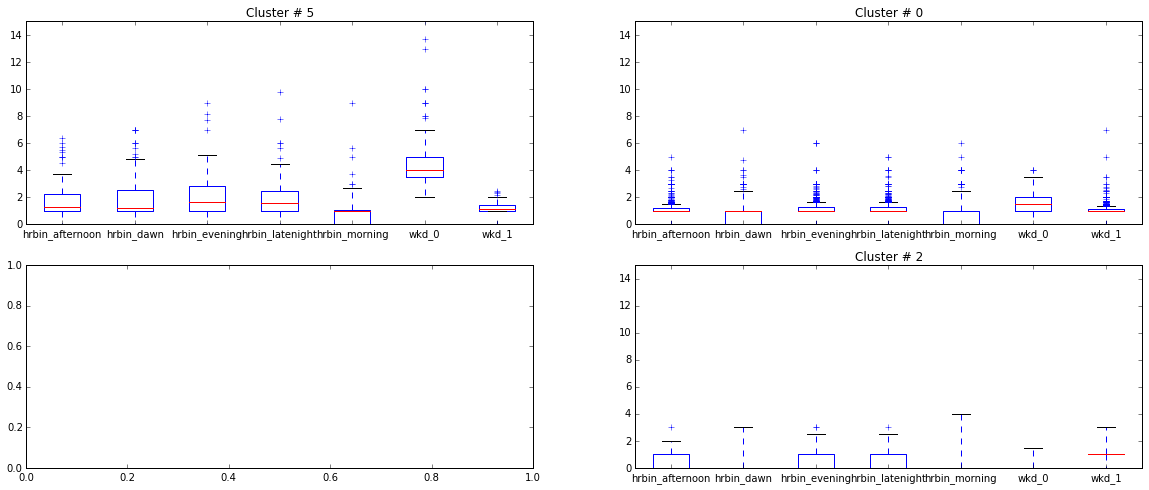

In [180]:
fig, axes = plt.subplots(nrows=2, ncols=2)
cluster5 = clusters[5]
dfk[dfk['hrbin_'].isin(cluster5)].plot(kind = 'box', title = 'Cluster # 5', figsize = (20,8),ylim = (0,15),ax=axes[0,0])

cluster5 = clusters[0]
dfk[dfk['hrbin_'].isin(cluster5)].plot(kind = 'box', title = 'Cluster # 0', figsize = (20,8), ylim = (0,15), ax=axes[0,1])

cluster5 = clusters[2]
dfk[dfk['hrbin_'].isin(cluster5)].plot(kind = 'box', title = 'Cluster # 2', figsize = (20,8), ylim = (0,15), ax=axes[1,1])